In [1]:
%load_ext autoreload
%autoreload 2

import sys         
sys.path.append('./../../src/') 
from data.ptbxl import create_features_dataset, get_feats_from_all_channels, load_ptbxl_data
from pathlib import Path
from signals.ecg import ECGSignal
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from signals.utils import parse_nested_feats
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed

TARGET = 'diagnostic_class'
DATASET_PATH = Path("./../../data/ptbxl")
SAMPLING_RATE = 100

In [334]:
ptbxl_data = load_ptbxl_data(
    sampling_rate=SAMPLING_RATE,
    path = DATASET_PATH,
    target = TARGET
)

In [335]:
ptbxl_dataset = create_features_dataset(ptbxl_data)

train split:   0%|          | 0/12978 [00:00<?, ?it/s]

val split:   0%|          | 0/1642 [00:00<?, ?it/s]

test split:   0%|          | 0/1652 [00:00<?, ?it/s]

In [336]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

# model = SVC(probability=True)
model = LGBMClassifier()


X_train = ptbxl_dataset['train']['X']
y_train = ptbxl_dataset['train']['y']

X_val = ptbxl_dataset['val']['X']
y_val = ptbxl_dataset['val']['y']

X_test = ptbxl_dataset['test']['X']
y_test = ptbxl_dataset['test']['y']

model.fit(X_train, y_train)

LGBMClassifier()

In [337]:
len(X_train), len(X_val), len(X_test)

(12972, 1640, 1652)

In [338]:
from evaluation.metrics import get_classification_metrics
from evaluation.visualisations import plot_feature_importance, plot_confusion_matrix

train_metrics = get_classification_metrics(model.predict_proba(X_train), y_train)
val_metrics = get_classification_metrics(model.predict_proba(X_val), y_val)
test_metrics = get_classification_metrics(model.predict_proba(X_test), y_test)

In [339]:
val_metrics, test_metrics

({'fscore': 0.6443300690778166,
  'acc': 0.774390243902439,
  'auc': 0.9239265426055882},
 {'fscore': 0.6554085305692593,
  'acc': 0.7790556900726392,
  'auc': 0.920301339451292})

In [42]:
val_metrics, test_metrics

({'fscore': 0.6247407970724964,
  'acc': 0.7576323987538941,
  'auc': 0.919570282475384},
 {'fscore': 0.6511467628590049,
  'acc': 0.7808814400993171,
  'auc': 0.9213483635956324})

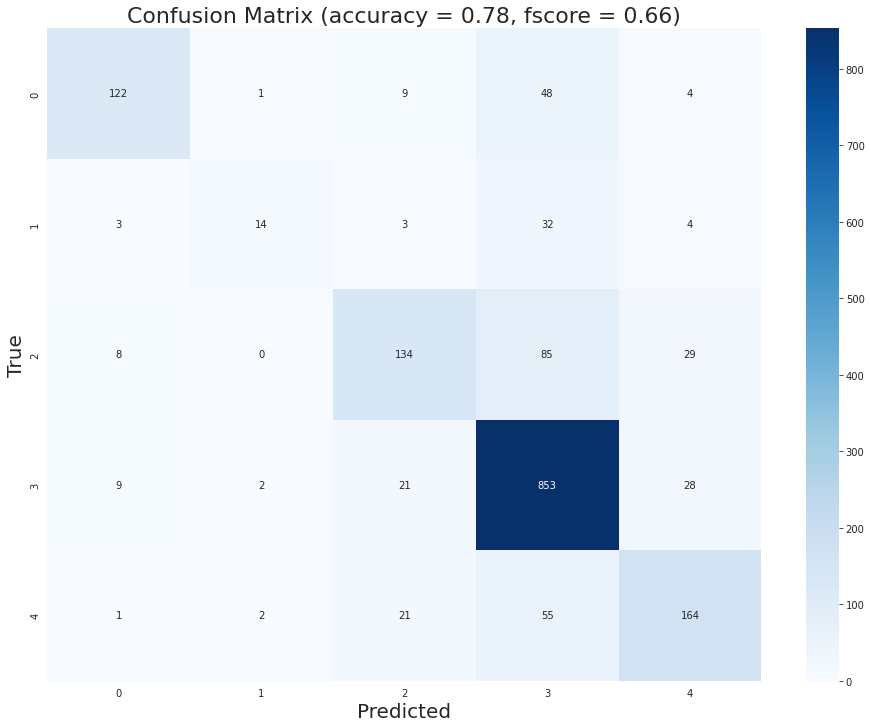

In [340]:
plot_confusion_matrix(y_test, model.predict(X_test), np.unique(y_train))

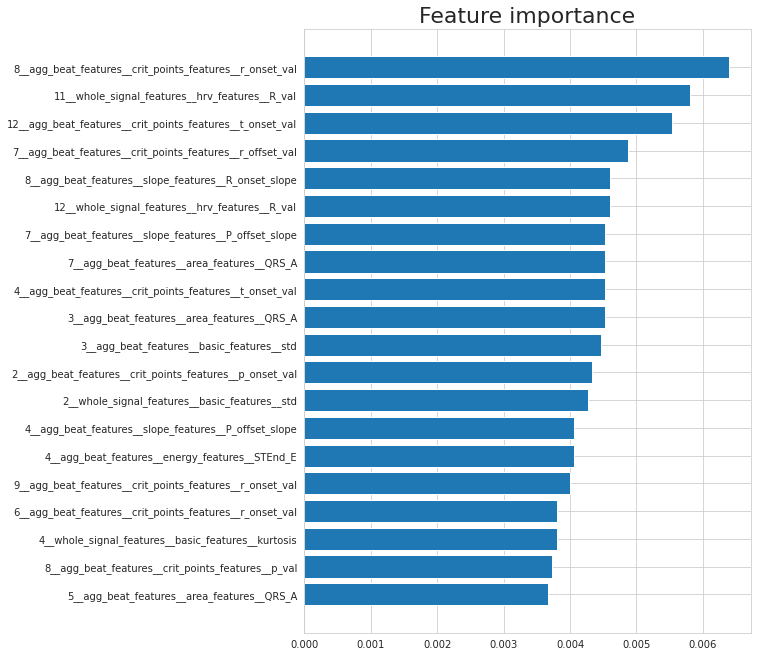

In [341]:
plot_feature_importance(X_train.columns.values, model.feature_importances_, n_best=20)

In [56]:
from torch import nn
import torch

class MLP(nn.Module):
    def __init__(self, in_size=1000, n_classes=5):
        super().__init__()
        self.model = nn.Sequential(
            # nn.Linear(in_size, in_size // 2),
            # nn.ReLU(),
            # nn.Linear(in_size // 2, in_size // 4),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(in_size, n_classes)
        )
        
    def forward(self, x):
        out = self.model(x)
        probs = F.softmax(out, dim=1)
        if torch.any(probs.isnan()) or torch.any(probs.isinf()):
            print(out)
        return probs

In [67]:
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from evaluation.metrics import get_classification_metrics

class PTBXLWaveFormClassifier(LightningModule):
    def __init__(self, in_dims, classifier: nn.Module, learning_rate: float = 1e-3):
        super().__init__()
        self.classifier = classifier
        self.learning_rate = learning_rate
        self.save_hyperparameters('in_dims', 'learning_rate')
    
    def forward(self, x):
        return self.classifier(x)

    def _common_step(self, batch, batch_ids, stage, log=True):
        x, labels = batch
        probs = self(x)
        log_probs = torch.log(probs)
        preds = log_probs.argmax(axis=1)
        if log:
            y_pred_proba = probs.detach().numpy()
            metrics = get_classification_metrics(y_pred_proba, labels, auc=stage in ('val', 'test'))
            for metric, val in metrics.items():
                self.log(f"{stage}/{metric}", val, on_step=False, on_epoch=True)
        return labels, probs, log_probs, preds
        
    def training_step(self, batch, batch_idx):
        labels, probs, log_probs, preds = self._common_step(batch, batch_idx, 'train', log=True)
        loss = F.nll_loss(log_probs, labels)
        return loss
    
    def validation_step(self, batch, batch_idx):
        labels, probs, log_probs, preds = self._common_step(batch, batch_idx, 'val', log=True)
        loss = F.nll_loss(log_probs, labels)
        return log_probs
    
    def predict_step(self, batch, batch_idx):
        _, _, _, preds = self._common_step(batch, batch_idx, 'predict', log=False)
        return preds

    def test_step(self, batch, batch_idx):
        _, _, _, preds = self._common_step(batch, batch_idx, 'test', log=True)
        return preds
    
    def test_epoch_end(self, test_step_outputs):
        pass
        # dummy_input = torch.zeros((1, self.hparams["in_dims"]), device=self.device)
        # model_filename = "model_final.onnx"
        # self.to_onnx(model_filename, dummy_input, export_params=True)
        # wandb.save(model_filename)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-3)

In [68]:
from data.ptbxl import PTBXLWaveformDataModule

ptbxl_datamodule = PTBXLWaveformDataModule(
    sampling_rate=100, target='diagnostic_class', batch_size=64, num_workers=8
)

mlp = MLP()
model = PTBXLWaveFormClassifier(1000, mlp, learning_rate=1e-3)
trainer = Trainer()
trainer.fit(model, ptbxl_datamodule)

/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name       | Type | Params
------------------------------------
0 | classifier | MLP  | 5.0 K 
------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Representations:

1. **Whole Signal as TimeSeries. Dimension: `[12 x 1000]`**
    * Samples in time, no processing needed
    
    
2. **Whole Signal as Features. Dimension: `[12 x D]`, where `D` represents number of features extracted from single channel**
    * For each channel extract `D` features:
        * basic features (i.e. `mean`, `std`, `skew`, `kurtosis`)
        * hrv features
        * aggregated beat features:
            * basic features
            * crit points features
            * etc.
        * AC/DC features
    * Features extracted between channels
    
    
3. **Whole Signal as embedding. Dimension: `[12 x D]`, where `D` represents size of embedding for a single channel**
    * Put waveform signals into embedding model and take embeddings as representation
    
    
4. **Per-beat features. Dimension: `[12 x K x D]`, where `K` is number of beats per channel and `D` is number of features extracted from single beat**
    * Beats are obtained from one channel (`source_channel`) and intervals from that channel are used to take beats from other channels
    * For each beat extract features
        * basic features
        * crit points features
        * etc.

In [2]:
from data.ptbxl import TENSORS_DATA_PATH
import torch
from biosppy.signals.ecg import ecg
from signals.ecg import create_multichannel_ecg, check_ecg_polarity
from tqdm.auto import tqdm

sampling_rate = 100
fs = sampling_rate
split = "train"

train_data = torch.load(TENSORS_DATA_PATH / f"records{sampling_rate}/{split}_data.pt")

In [3]:
train_data.shape

torch.Size([12978, 1000, 12])

In [49]:
REPRESENTATIONS_DATA_PATH = DATASET_PATH / 'representations_100'

def get_representations(channels_data, fs=100):
    multi_ecg = create_multichannel_ecg(channels_data.T.numpy(), 100)

    n_beats = 10
    multi_ecg.get_beats(source_channel=2)
    whole_signal_waveforms = multi_ecg.get_waveform_representation()
    whole_signal_features = multi_ecg.get_whole_signal_features_representation()
    per_beat_waveforms = multi_ecg.get_per_beat_waveform_representation(n_beats=n_beats)
    per_beat_features = multi_ecg.get_per_beat_features_representation(n_beats=n_beats)

    actual_beats = per_beat_waveforms.shape[1]
    n_more_beats = n_beats - actual_beats
    # print(f"{actual_beats} beats in signal. Padding {n_more_beats} beats")
    per_beat_waveforms = np.pad(per_beat_waveforms, ((0, 0), (0, n_more_beats), (0, 0)))
    per_beat_features = np.pad(per_beat_features, ((0, 0), (0, n_more_beats), (0, 0)))

    return {
        'whole_signal_waveforms': whole_signal_waveforms,
        'whole_signal_features': whole_signal_features,
        'per_beat_waveforms': per_beat_waveforms,
        'per_beat_features': per_beat_features,
    }

def create_representations_dataset(splits=['train', 'val', 'test']):
    for split in tqdm(splits):
        data = torch.load(TENSORS_DATA_PATH / f"records{sampling_rate}/{split}_data.pt")
        representations = Parallel(n_jobs=-1)(delayed(get_representations)(channels) for channels in tqdm(data))
        representation_names = representations[0].keys()
        representations = {name: torch.tensor(np.array([rep[name] for rep in representations])) for name in representation_names}
        for name, representation_data in representations.items():
            path = REPRESENTATIONS_DATA_PATH / name / f"{split}_data.pt"
            torch.save(representation_data, path)

In [ ]:
create_representations_dataset(splits=['val'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1642 [00:00<?, ?it/s]

In [223]:
for i in tqdm(range(len(data))):
    try:
        multi_ecg = create_multichannel_ecg(data[i].T.numpy(), 100)
        feats = multi_ecg.get_whole_signal_features_representation()
    except Exception:
        print(i)
        continue

  0%|          | 0/12978 [00:00<?, ?it/s]

207
347


/home/shate/.local/lib/python3.8/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in true_divide
  mrrs /= th2
/home/shate/.local/lib/python3.8/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in true_divide
  mrrs /= th2


899
989
1126
1168
1191
1317
1631
1718
1743
1764
1841


/home/shate/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shate/.local/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:68: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


2323
2342
2555
2633
2722
2753
3142


/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3447
3662
3962
3983
4009
4012
4401
4409
4548
5005


KeyboardInterrupt: 

In [322]:
idx = bad_idxs[3]
multi_ecg = create_multichannel_ecg(data[0].T.numpy(), 100)

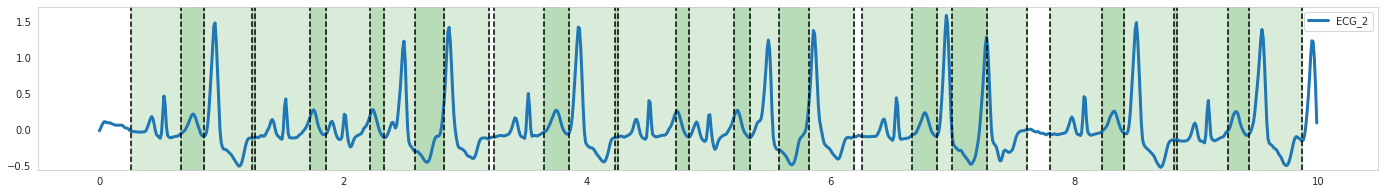

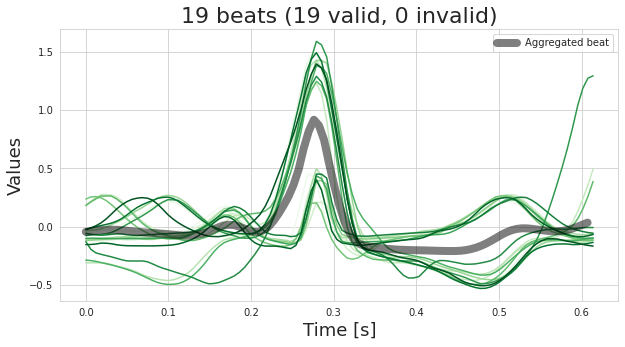

In [317]:
multi_ecg.signals[2].get_beats(align_to_r=True)
multi_ecg.signals[2].aggregate()
multi_ecg.signals[2].plot_beats_segmentation()
multi_ecg.signals[2].plot_beats()

In [124]:
def get_beats_from_all_channels(channels, fs=100):
    try:
        multi_ecg = create_multichannel_ecg(channels.T, fs=fs)
        beats = multi_ecg.get_beats(source_channel=2, return_arr=True)
        return beats
    except Exception:
        return None

# multi_ecg_beats_data = Parallel(n_jobs=-1)(delayed(get_beats_from_all_channels)(channels) for channels in tqdm(data))
multi_ecg_beats_data = [get_beats_from_all_channels(channels) for channels in tqdm(data)]
multi_ecg_beats_data = [el for el in multi_ecg_beats_data if el is not None]
num_beats = np.array([el.shape[1] for el in multi_ecg_beats_data])
sns.histplot(num_beats)

  0%|          | 0/12978 [00:00<?, ?it/s]

/home/shate/.local/lib/python3.8/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in true_divide
  mrrs /= th2
/home/shate/.local/lib/python3.8/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in true_divide
  mrrs /= th2
/home/shate/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shate/.local/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:68: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


In [ ]:
class PTBXLPerBeatWaveformDataset(Dataset):
    """PTB-XL Dataset class used in DeepLearning models."""

    def __init__(self, split, sampling_rate=100, target="diagnostic_class", transform=None):
        # TODO: target is still not used -> only diagnostic_class labels are saved as tensors
        # TODO: sampling_rate works only for 100 -> 100 fs samples are saves as tensors

        self.data = torch.load(TENSORS_DATA_PATH / f"records{sampling_rate}/{split}_data.pt")
        self.labels = np.load(TENSORS_DATA_PATH / f"records{sampling_rate}/{split}_labels.npy", allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.data[idx][:, 0].float(), self.labels[idx]


class PTBXLPerBeatWaveformDataModule(LightningDataModule):
    """PTB-XL DataModule class used as DeepLearning models DataLoaders provider."""

    def __init__(self, sampling_rate=100, target="diagnostic_class", batch_size: int = 64, num_workers=8):
        super().__init__()
        self.sampling_rate = sampling_rate
        self.target = target
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train = None
        self.val = None
        self.test = None

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train = PTBXLWaveformDataset(split="train", sampling_rate=self.sampling_rate, target=self.target)
            self.val = PTBXLWaveformDataset(split="val", sampling_rate=self.sampling_rate, target=self.target)
        if stage == "test" or stage is None:
            self.test = PTBXLWaveformDataset(split="test", sampling_rate=self.sampling_rate, target=self.target)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=10 * self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=10 * self.batch_size, num_workers=self.num_workers)
